In [1]:
using Distributions
using PyPlot
import Statistics
import StatsBase
using PyCall
using SpecialFunctions
@pyimport pickle

## Goodness of fit tests for the fitted neutral models

Look at three goodness-of-fit statistics for each of the seven models

1. Overall
2. Data point-specific
3. OTU-specific

In [5]:
"""
Log-likelihood for the dirchelet-multinomial

Parameters
----------
- x : abundance array
- alphas : dirichlet parameter array

Returns
-------
- log-likelihood of x under model
"""
function dirichlet_multinomial(x, alphas)

    n = sum(x)
    alpha0 = sum(alphas)

    norm_factor = lgamma(n + 1) + lgamma(alpha0) - lgamma(n + alpha0)
    prod_factor = sum(lgamma.(x .+ alphas) .- (lgamma.(x .+ 1.0) .+ lgamma.(alphas)))
    logpdf = norm_factor + prod_factor

    return(logpdf)
end

dirichlet_multinomial

In [39]:
"""
Dirichlet-Multinomial neutral model with main effects on dispersal

Parameters
----------
- stanfit : Dict from fitted stan object
- standata : Dict used when fitting stan object
- samples : int, number of random datasets to generate
- main_effects : bool, if true allows meta_p to vary with sample

Returns
-------
- Dict
    - full_pred : (N, samples) likelihood for each datapoint in simulated datasets
    - full_obs :  (N, samples) likelihood for each datapoint in observed datasets
    - marg_pred : (S, samples) likelihood for each OTU across samples in simulated datasets
    - marg_obs :  (S, samples) likelihood for each OTU across samples in observed dataset
"""
function model_dispersal(stanfit, standata; samples=500, mean_effects=false)
    
    S = standata["S"]
    P = standata["P"]
    X = standata["X"]
    N = standata["N"]
    Nt_vals = standata["Nt"]
    abund = standata["abund"]

    # Number of samples in posterior
    sim_n = size(stanfit["beta"])[1]
    inds = rand(1:sim_n, samples)

    # Save the results
    full_lik_pred = rand(N, samples)
    full_lik_obs = rand(N, samples)
    marginal_lik_pred = rand(S - 1, samples)
    marginal_lik_obs = rand(S - 1, samples)

    for (sid, samp_id) in enumerate(inds)

        # Fitted parameters
        β = stanfit["beta"][samp_id, :]
        I = exp.(X * β)
        
        if !mean_effects
            meta_p = stanfit["meta_p"][samp_id, :]
            α = [tI .* meta_p for tI in I]
        else
            meta_p = stanfit["meta_p"][samp_id, :, :]
            α = [tI .*  meta_p[n, :] for (n, tI) in enumerate(I)]
        end

        # Process model
        πs = [rand(Dirichlet(α[i]), 1) for i in 1:N]

        # Observation model
        mult_mods = [Multinomial(Nt, reshape(tπ, size(tπ)[1])) for (Nt, tπ) in zip(Nt_vals, πs)]
        y_pred = [rand(mmod, 1) for mmod in mult_mods]

        # Multivariate log-likelihoods
        y_like = [dirichlet_multinomial(ty, talpha) for (ty, talpha) in zip(y_pred, α)]
        obs_like = [dirichlet_multinomial(abund[i, :], α[i]) for i in 1:N]
        full_lik_pred[:, sid] = copy(y_like)
        full_lik_obs[:, sid] = copy(obs_like)

        # Marginal log-likelihoods
        y_pred2 = hcat(y_pred...)'
        marg_like = rand(N, S - 1)
        marg_like_obs = rand(N, S - 1)
        for s in 1:(S - 1)
            for j in 1:N
                
                if !mean_effects
                    talphas = [I[j]*meta_p[s], I[j]*(1 - meta_p[s])]
                else
                    talphas = [I[j]*meta_p[j, s], I[j]*(1 - meta_p[j, s])]
                end
                
                marg_like[j, s] = dirichlet_multinomial([y_pred2[j, s], Nt_vals[j] - y_pred2[j, s]], talphas)
                marg_like_obs[j, s] = dirichlet_multinomial([abund[j, s], Nt_vals[j] - abund[j, s]], talphas)
            end
        end
                
        marg_sum = sum(marg_like, dims=1)
        marg_sum_obs = sum(marg_like_obs, dims=1)
        marginal_lik_pred[:, sid] = copy(marg_sum)
        marginal_lik_obs[:, sid] = copy(marg_sum_obs)

    end
    
    return(Dict("full_pred"=>full_lik_pred, "full_obs"=>full_lik_obs, 
                "marg_pred"=>marginal_lik_pred, "marg_obs"=>marginal_lik_obs))
end



model_dispersal

In [40]:
"""
Likelihood of models with random effects of OTUs on dispersal

Parameters
----------
- stanfit : Dict from fitted stan object
- standata : Dict used when fitting stan object
- samples : int, number of random datasets to generate

Returns
-------
- Dict
    - full_pred : (N, samples) likelihood for each datapoint in simulated datasets
    - full_obs :  (N, samples) likelihood for each datapoint in observed datasets
    - marg_pred : (S, samples) likelihood for each OTU across samples in simulated datasets
    - marg_obs :  (S, samples) likelihood for each OTU across samples in observed dataset

"""
function model_betabinom(stanfit, standata; samples=500, random_effects=false)
    
    S = standata["S"] # Number of species
    P = standata["P"] # Number of predictor variables for disspersal effects
    X = standata["X"] # Design matrix for dispersal effects
    N = standata["N"] # Number of samples
    G = standata["G"] # Number of random effects (OTU-specific) on dispersal
    Z = standata["Z"] # Design matrix for random OTU-specific effects on dispersal
    
    # Abundance per sample
    Nt_vals = convert(Array{Int64, 1}, round.(standata["Nt"]))
    abund = standata["abund"]

    # Number of samples in posterior
    sim_n = size(stanfit["beta"])[1]
    inds = rand(1:sim_n, samples)

    # Save the results
    full_lik_pred = rand(N, samples)
    full_lik_obs = rand(N, samples)
    marginal_lik_pred = rand(S - 1, samples)
    marginal_lik_obs = rand(S - 1, samples)
    full_ypred = rand(samples, N, S - 1)
    
    if random_effects
        sigmas = stanfit["sigmas"][inds, :]
    else
        sigmas = rand(samples, 1)
    end
    
    for (sid, samp_id) in enumerate(inds)
        
        # Fitted parameters
        meta_p = stanfit["meta_p"][samp_id, :, :]
        
        if random_effects
            β = stanfit["Beta"][samp_id, :, :]
            Ω = stanfit["Omega"][samp_id, :, :]
            I = exp.(X*β + Z*Ω)
        else
            β = try
                    stanfit["Beta"][samp_id, :, :]
                catch
                    β_small = stanfit["beta"][samp_id, :]
                    hcat([β_small for i in 1:(S - 1)]...)
                end
            I = exp.(X*β)
        end
        
        # Simulate data and get likelihood
        y_pred = floor.(Int, rand(N, (S - 1)))
        pred_like = rand(N, (S - 1))
        obs_like = rand(N, (S - 1))

        for s in 1:(S - 1) 

            tbeta = Beta.(I[:, s].*meta_p[:, s], I[:, s].*(1 .- meta_p[:, s]))
            pis = vcat(rand.(tbeta, 1)...)
            ty = vcat(rand.(Binomial.(Nt_vals, pis), 1)...)
            y_pred[:, s] = ty
 
            tpred = rand(N)
            tobs = rand(N)
            for n in 1:N
                α = [I[n, s]*meta_p[n, s], I[n, s]*(1 .- meta_p[n, s])]
                tpred[n] = dirichlet_multinomial([ty[n], Nt_vals[n] - ty[n]], α)
                tobs[n] = dirichlet_multinomial([abund[n, s], Nt_vals[n] - abund[n, s]], α)
            end

            pred_like[:, s] = tpred
            obs_like[:, s] = tobs

        end
        
        full_ypred[sid, :, :] = y_pred
        full_lik_pred[:, sid] = sum(pred_like, dims=2)
        full_lik_obs[:, sid] = sum(obs_like, dims=2)
        marginal_lik_pred[:, sid] = sum(pred_like, dims=1)'
        marginal_lik_obs[:, sid] = sum(obs_like, dims=1)'
    
    end
    
    return(Dict("full_pred"=>full_lik_pred, "full_obs"=>full_lik_obs, 
                "marg_pred"=>marginal_lik_pred, "marg_obs"=>marginal_lik_obs,
                "pred_y"=>full_ypred, "sigmas"=>sigmas))

end


model_betabinom

In [41]:
# models = ["base",
#  "mean-lake",
#  "mean-lake_I-svl",
#  "mean-lake_I-svl-Bd",
#  "mean-lake_I-svl-Bd2",
#  "mean-lake_I-svl-Bd2_random",
#  "mean-lake_I-svl-Bd2_random-Bd",
#  "mean-lake-Bd_I-svl-Bd2_random-Bd",
#  "mean-lake-Bd2_I-svl-Bd2_random-Bd",
#  "mean-lake-Bd2_I-svl-Bd2_random",
#  "mean-lake-Bd2_I-svl_random",
#  "mean-lake-Bd2_I-svl-Bd_random",
#  "mean-lake-Bd2_I-svl-Bd_random-Bd",
#  "mean-lake_I-svl-Bd_random-Bd", 
#  "mean-Bd2_I-svl-Bd_random-Bd", 
#  "I-svl-Bd_random-Bd", 
#  "mean-lake-Bd2_I-svl-Bd", 
#  "mean-lake-Bd2"]

models = ["mean-lake", "mean-lake-Bd2-int_I-svl-Bd-lake_random-Bd"]
#models = ["mean-lake", "mean-lake_I-svl-lake_random"]
#rand_effects = append!(repeat([false], 5), repeat([true], 11))
#rand_effects = append!(rand_effects, [false, false])
rand_effects = [false, true]
lik_res = Dict()
for (m, model) in enumerate(models)
    println(model)
    nm = "../results/model_fits/$model-numOTU19.pkl"
    fo = open(nm, "r")
    stanfit, standata, X, Z, W, bd_load = pickle.load(fo)
    lik_res["$model"] = model_betabinom(stanfit, standata; samples=500, random_effects=rand_effects[m])
end

mean-lake
mean-lake-Bd2-int_I-svl-Bd-lake_random-Bd


In [42]:


#models_lab = ["mean-treatment", "mean-treatment-Bd2_I-svl-Bd_random-Bd"]
models_lab = ["mean-treatment", "mean-treatment-Bd2_I-svl-Bd_random-Bd"]
#rand_effects = append!(repeat([false], 5), repeat([true], 11))
#rand_effects = append!(rand_effects, [false, false])
rand_effects = [false, true]
lik_res_lab = Dict()
for (m, model) in enumerate(models_lab)
    println(model)
    nm = "../results/model_fits/$model-numOTU19_lab.pkl"
    fo = open(nm, "r")
    stanfit, standata, X, Z, W, bd_load = pickle.load(fo)
    lik_res_lab["$model"] = model_betabinom(stanfit, standata; samples=500, random_effects=rand_effects[m])
end

mean-treatment
mean-treatment-Bd2_I-svl-Bd_random-Bd


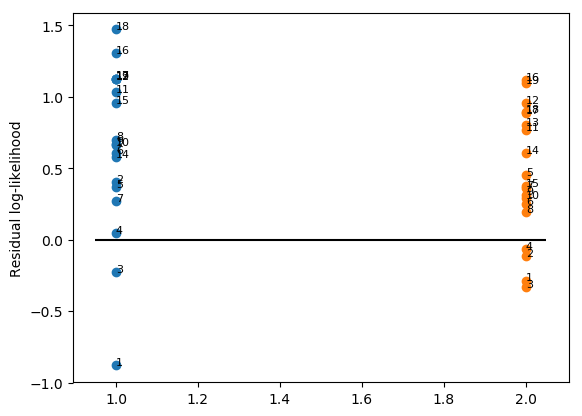

PyObject Text(24.000000000000007, 0.5, 'Residual log-likelihood')

In [7]:
# OTU-Specific GOF

fig, axes = subplots(1, 1)
for (j, modelnm) in enumerate(models)

    S = size(lik_res["$modelnm"]["marg_pred"])[1]
    pred_means = mean(lik_res["$modelnm"]["marg_pred"], dims=2)
    pred_sds = std(lik_res["$modelnm"]["marg_pred"], dims=2)
    obs_means =  mean(lik_res["$modelnm"]["marg_obs"], dims=2)
    resid = (obs_means .- pred_means) ./ pred_sds

    axes[:plot](repeat([j], S), resid, marker="o", linestyle="")

    for i in 1:size(resid)[1]
        axes[:text](j, resid[i], string(i), size=8)
    end
end

# axes[:set_xticks](collect(1:length(models)))
# axes[:set_xticklabels](models, rotation=90)
axes[:hlines](0, axes[:get_xlim]()...)
axes[:set_ylabel]("Residual log-likelihood")

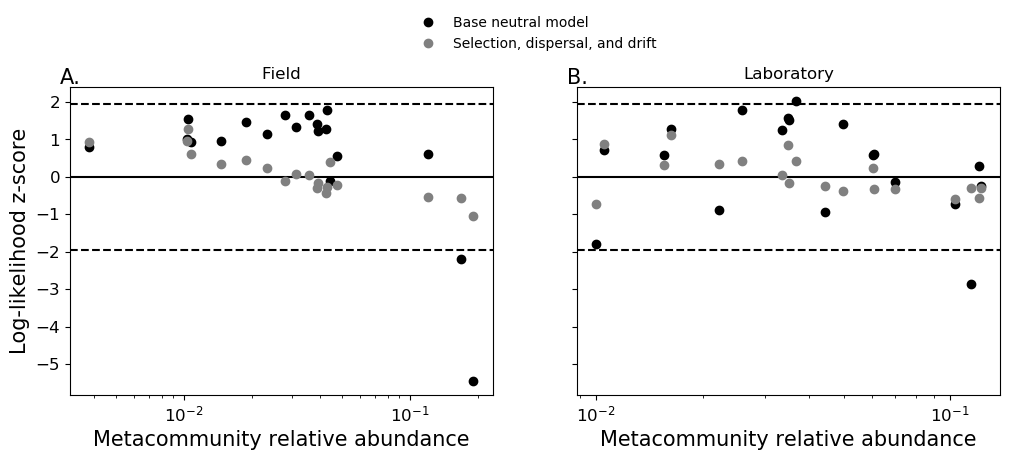

In [97]:
# OTU-Specific GOF

fig, axes = subplots(1, 2, figsize=(12, 4), sharey=true)
axes = vcat(axes...)
pretty_names = ["Base neutral model", "Selection, dispersal, and drift"]
likes = [lik_res, lik_res_lab]
modnms = [models, models_lab]
suffix = ["", "_lab"]
letters = ["A.", "B."]
titles = ["Field", "Laboratory"]
colors=["black", "gray"]

for i in 1:2
    
    ax = axes[i]
    
    for (j, modelnm) in enumerate(modnms[i])

        S = size(likes[i]["$modelnm"]["marg_pred"])[1]
        pred_means = mean(likes[i]["$modelnm"]["marg_pred"], dims=2)
        pred_sds = std(likes[i]["$modelnm"]["marg_pred"], dims=2)
        obs_means =  mean(likes[i]["$modelnm"]["marg_obs"], dims=2)
        resid = (obs_means .- pred_means) ./ pred_sds

        # Observed abundance
        suf = suffix[i]
        nm = "../results/model_fits/base-numOTU19$suf.pkl"
        fo = open(nm, "r")
        stanfit, standata, X, Z, W, bd_load = pickle.load(fo)
        meta_p = vcat(mean(stanfit["meta_p"], dims=(1, 2))...)

        ax[:semilogx](meta_p, resid, marker="o", linestyle="", color=colors[j], label=pretty_names[j])

    #     for i in 1:size(resid)[1]
    #         axes[:text](j, resid[i], string(i), size=8)
    #     end
    end
    
    xlim =  ax[:get_xlim]()
    ax[:hlines](0, xlim...)
    ax[:hlines](1.96, xlim..., linestyle="dashed")
    ax[:hlines](-1.96, xlim..., linestyle="dashed")
    ax[:set_xlabel]("Metacommunity relative abundance", size=15)
    ax[:tick_params](labelsize=12)
    ax[:text](0, 1.01, letters[i], size=15, ha="center", transform=ax[:transAxes])
    ax[:set_title](titles[i], size=12)
    ax[:set_xlim](xlim)
    
    if i == 1
        ax[:legend](loc=(0.8, 1.1), fontsize=10, frameon=false)
        ax[:set_ylabel]("Log-likelihood z-score", size=15)
    end

end

plt[:savefig]("../results/gof_tests.pdf", bbox_inches="tight")

Is the approximate 2 and -2 line reasonable for a GOF test? Looks like it

In [82]:
colmeans =  mean(lik_res["mean-lake"]["marg_pred"], dims=2)
colsds = std(lik_res["mean-lake"]["marg_pred"], dims=2)

demeaned = [(lik_res["mean-lake"]["marg_pred"][i, :] .- colmeans[i]) ./ colsds[i]
                            for i in 1:length(colmeans)]
td = Array(hcat(demeaned...)')

quants = [Statistics.quantile(td[i, :], [0.025, .975]) for i in 1:size(td)[1]]

19-element Array{Array{Float64,1},1}:
 [-1.93291, 1.94465]
 [-1.83319, 2.00499]
 [-1.76946, 2.04703]
 [-1.84276, 1.98341]
 [-1.92582, 1.88417]
 [-1.86523, 2.00164]
 [-1.9991, 1.8948]  
 [-1.80808, 2.00464]
 [-1.80718, 1.87837]
 [-1.96797, 1.85741]
 [-1.98748, 1.73605]
 [-1.89484, 1.87507]
 [-1.90679, 1.91999]
 [-1.8903, 1.91751] 
 [-1.80041, 1.84443]
 [-1.84154, 1.8961] 
 [-2.10344, 1.85431]
 [-1.87016, 1.99455]
 [-2.09956, 1.85026]

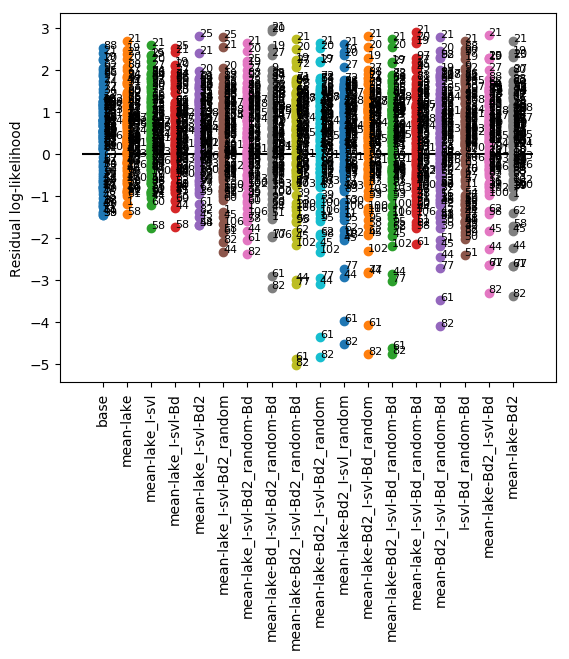

PyObject Text(24.000000000000007, 0.5, 'Residual log-likelihood')

In [17]:

fig, axes = subplots(1, 1)
for (j, modelnm) in enumerate(models)

    S = size(lik_res["$modelnm"]["full_pred"])[1]
    pred_means = mean(lik_res["$modelnm"]["full_pred"], dims=2)
    pred_sds = std(lik_res["$modelnm"]["full_pred"], dims=2)
    obs_means =  mean(lik_res["$modelnm"]["full_obs"], dims=2)
    resid = (obs_means .- pred_means) ./ pred_sds

    axes[:plot](repeat([j], S), resid, marker="o", linestyle="")

    for i in 1:size(resid)[1]
        axes[:text](j, resid[i], string(i), size=8)
    end
end

axes[:set_xticks](collect(1:length(models)))
axes[:set_xticklabels](models, rotation=90)
axes[:hlines](0, axes[:get_xlim]()...)
axes[:set_ylabel]("Residual log-likelihood")

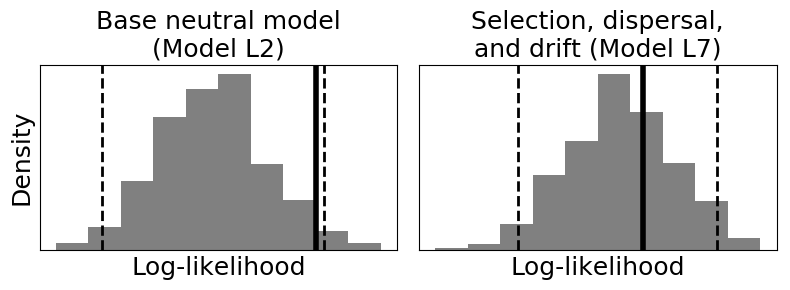

In [92]:
# Datapoint specific GOF

fig, axes = subplots(1, 2, figsize=(8, 3), sharex=false, sharey=false)
pretty_title = ["Base neutral model\n(Model L2)", "Selection, dispersal,\nand drift (Model L7)"]

for (j, modelnm) in enumerate(models_lab)

    pred_like = vcat(sum(lik_res_lab["$modelnm"]["full_pred"], dims=1)...)
    (lower, upper) = Statistics.quantile(pred_like, [.025, .975])
    obs = mean(sum(lik_res_lab["$modelnm"]["full_obs"], dims=1))
    
    ptitle = pretty_title[j]
    axes[j][:hist](pred_like, density=true, color="gray")
    ylim = axes[j][:get_ylim]()
    axes[j][:vlines](obs, ylim..., linewidth=4)
    axes[j][:set_title]("$ptitle", size=18)
    axes[j][:tick_params](labelleft=false, labelbottom=false, bottom=false, left=false)
    axes[j][:set_xlabel]("Log-likelihood", size=18)
    axes[j][:vlines](lower, ylim..., linewidth=2, linestyle="dashed")
    axes[j][:vlines](upper, ylim..., linewidth=2, linestyle="dashed")
    axes[j][:set_ylim](ylim)
    #axes[j][:spines]
    
    if j == 1
        axes[j][:set_ylabel]("Density", size=18)
    end

end

tight_layout()
plt[:savefig]("../results/gof_overall_lab.pdf", bbox_inches="tight")

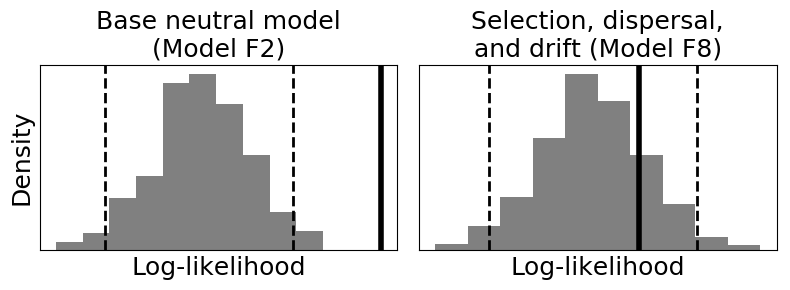

In [96]:
# Datapoint specific GOF

fig, axes = subplots(1, 2, figsize=(8, 3), sharex=false, sharey=false)
pretty_title = ["Base neutral model\n(Model F2)", "Selection, dispersal,\nand drift (Model F8)"]

for (j, modelnm) in enumerate(models)

    pred_like = vcat(sum(lik_res["$modelnm"]["full_pred"], dims=1)...)
    (lower, upper) = Statistics.quantile(pred_like, [.025, .975])
    obs = mean(sum(lik_res["$modelnm"]["full_obs"], dims=1))
    
    ptitle = pretty_title[j]
    axes[j][:hist](pred_like, density=true, color="gray")
    ylim = axes[j][:get_ylim]()
    axes[j][:vlines](obs, ylim..., linewidth=4)
    axes[j][:set_title]("$ptitle", size=18)
    axes[j][:tick_params](labelleft=false, labelbottom=false, bottom=false, left=false)
    axes[j][:set_xlabel]("Log-likelihood", size=18)
    axes[j][:vlines](lower, ylim..., linewidth=2, linestyle="dashed")
    axes[j][:vlines](upper, ylim..., linewidth=2, linestyle="dashed")
    axes[j][:set_ylim](ylim)
    #axes[j][:spines]
    
    if j == 1
        axes[j][:set_ylabel]("Density", size=18)
    end

end

tight_layout()
plt[:savefig]("../results/gof_overall_field.pdf", bbox_inches="tight")

 I think the major problem with the fit is not letting the OTU-specific effects vary across sites. Really going to up the number of parameters though....

---

## R^2 to decompose dispersal, drift, and selection

In [48]:
function logit(a)
    return(log(a / (1 - a)))
end

logit (generic function with 1 method)

In [11]:
# Calculating the R2 value on the response scale

for i in 1:2
    
    R2_vals = Dict()
    for (m, model) in enumerate(modnms[i])

        suf = suffix[i]
        nm = "../results/model_fits/$model-numOTU19$suf.pkl"
        fo = open(nm, "r")
        stanfit, standata, X, Z, W, bd_load = pickle.load(fo)

        tR2 = rand(1)
        for (l, lr) in enumerate([likes[i]])

            py = lr["$model"]["pred_y"]
            #pred_relabund = [py[t, :, :] ./ standata["Nt"] for t in 1:size(py)[1]]
            pred_relabund = [py[t, :, :] for t in 1:size(py)[1]]

            obs = standata["abund"][:, 1:(end - 1)] #./ standata["Nt"]
            #loglink_resid = [logit.(obs) .- logit.(pred) for pred in pred_relabund]
            loglink_resid = [obs .- pred for pred in pred_relabund]

            var_resids = [var(tresids[.!(isnan.(tresids) .| (tresids .== -Inf) .| (tresids .== Inf))]) 
                                                for tresids in loglink_resid]

            if rand_effects[m]
                sigmas = 0#sum(lr["$model"]["sigmas"], dims=2)
            else
                sigmas = 0
            end

            #logit_pred = [logit.(pred) for pred in pred_relabund]
            logit_pred = [pred for pred in pred_relabund]
            var_pred = [var(lpred[.!(isnan.(lpred) .| (lpred .== -Inf) .| (lpred .== Inf))]) for lpred in logit_pred]
            R2 = mean((var_pred .+ sigmas) ./ (var_pred .+ sigmas .+ var_resids))
            tR2[l] = R2
        end
            println(model*" "*string(tR2))
            R2_vals[model] = tR2

    end
end
    

DimensionMismatch: DimensionMismatch("arrays could not be broadcast to a common size")

In [268]:
lik_res["$model"]["sigmas"]

500×1 Array{Float64,2}:
 0.6605319488532089  
 0.853562018535672   
 0.8015354172478941  
 0.16032960659410844 
 0.8489519881166829  
 0.698088399324235   
 0.8581461423361669  
 0.030273625067779752
 0.2898552196627846  
 0.11216877972737982 
 0.7899341989255242  
 0.5531341030427939  
 0.21458231232257985 
 ⋮                   
 0.14053716529615135 
 0.8803685681034743  
 0.8362205820351669  
 0.7767410773743111  
 0.07459579257182614 
 0.2734320993450512  
 0.826042333548199   
 0.8086359041539577  
 0.2742840798504316  
 0.8548700974135885  
 0.8614379141291211  
 0.35464297955057855 

In [255]:
loglink_resid[1][(.!(loglink_resid[1] .== -Inf))]

1763-element Array{Float64,1}:
  -2.4003950972259007 
  -0.4836253974668341 
   1.438161941716759  
   0.9576174673648551 
  -0.32045624933516326
  -1.707558751405855  
   1.206889377120235  
   2.055123287754801  
   1.8708420343840586 
   1.8706029657536165 
   2.1373538276953554 
   1.5537501671508598 
  -0.14079311989902887
   ⋮                  
 NaN                  
  -4.478718348200131  
  -2.948496694382304  
  -5.326804514951386  
 Inf                  
  -4.16551193850718   
 Inf                  
  -1.1202585628955526 
   0.38682682282706793
 NaN                  
 NaN                  
   2.0848365451314947 

In [249]:
resids = vcat(vcat(loglink_resid...)...)
ind = isnan.(resids) .| (resids .== -Inf) .| (resids .== Inf)
cleaned_resids = resids[.!ind]

501681-element Array{Float64,1}:
 -2.4003950972259007 
 -0.4836253974668341 
  1.438161941716759  
  0.9576174673648551 
 -0.32045624933516326
 -1.707558751405855  
  1.206889377120235  
  2.055123287754801  
  1.8708420343840586 
  1.8706029657536165 
  2.1373538276953554 
  1.5537501671508598 
 -0.14079311989902887
  ⋮                  
 -0.6361194771312668 
  0.0                
 -4.433319929061432  
  0.1181106359869144 
 -2.7829372105900916 
 -4.20454108127884   
 -1.620780189038035  
 -2.3817488277001884 
 -5.684264698872307  
 -0.18317009311979415
  0.0                
 -1.4350598582937613 

In [214]:
#py = lik_res["$model"]["pred_y"]
#pred_relabund = [py[t, :, :] ./ standata["Nt"] for t in 1:size(py)[1]]
vcat(vcat(pred_relabund...)...)

1026000-element Array{Float64,1}:
 0.16666666666666666 
 0.2543624161073825  
 0.34324659231722426 
 0.1324404761904762  
 0.16                
 0.36212624584717606 
 0.17770232031692135 
 0.3540530716103235  
 0.09815720195562241 
 0.30740140464613724 
 0.14471544715447154 
 0.07816711590296496 
 0.20861900097943192 
 ⋮                   
 0.0                 
 0.054027504911591355
 0.0                 
 0.12139737991266375 
 0.0                 
 0.0                 
 0.022743425728500355
 0.0                 
 0.09869848156182212 
 0.021534320323014805
 0.0                 
 0.08525345622119816 

In [212]:
pred_relabund[1]

108×19 Array{Float64,2}:
 0.166667   0.230241   0.0         0.0          …  0.0          0.0463918 
 0.254362   0.218792   0.0167785   0.00268456      0.0          0.102013  
 0.343247   0.143742   0.0805452   0.0             0.379182     0.00123916
 0.13244    0.047619   0.172619    0.0             0.0014881    0.0       
 0.16       0.077037   0.0192593   0.00444444      0.197037     0.00296296
 0.362126   0.0398671  0.0         0.0          …  0.00332226   0.00664452
 0.177702   0.177136   0.251839    0.0             0.0379174    0.00169779
 0.354053   0.0167212  0.087968    0.000363504     0.0          0.0       
 0.0981572  0.151561   0.506958    0.0225649       0.101918     0.0       
 0.307401   0.0324149  0.129119    0.0             0.0010805    0.0102647 
 0.144715   0.0317073  0.160163    0.000813008  …  0.00569106   0.0357724 
 0.0781671  0.30593    0.0         0.0             0.00673854   0.083558  
 0.208619   0.119001   0.0808031   0.0612145       0.000489716  0.0       


In [202]:
standata["Nt"]

108-element Array{Int64,1}:
  582
 1490
  807
  672
  675
  301
 1767
 2751
 2659
 1851
 1230
  742
 2042
    ⋮
 4446
 2036
 1184
 1145
  755
  978
 1407
  478
 1844
  743
 1353
 1302

In [204]:
t

108×19 Array{Float64,2}:
   97.0   134.0     0.0    0.0    1.0  …    0.0    0.0   20.0    0.0   27.0
  379.0   326.0    25.0    4.0  112.0       0.0   60.0    0.0    0.0  152.0
  277.0   116.0    65.0    0.0   14.0       0.0    0.0    0.0  306.0    1.0
   89.0    32.0   116.0    0.0    0.0       0.0    0.0   12.0    1.0    0.0
  108.0    52.0    13.0    3.0    0.0      35.0    0.0    8.0  133.0    2.0
  109.0    12.0     0.0    0.0    0.0  …    0.0    0.0    0.0    1.0    2.0
  314.0   313.0   445.0    0.0   36.0       0.0    0.0    4.0   67.0    3.0
  974.0    46.0   242.0    1.0    0.0       0.0    0.0    0.0    0.0    0.0
  261.0   403.0  1348.0   60.0    0.0      36.0    0.0  143.0  271.0    0.0
  569.0    60.0   239.0    0.0  318.0       0.0    0.0   38.0    2.0   19.0
  178.0    39.0   197.0    1.0    7.0  …   57.0    0.0    0.0    7.0   44.0
   58.0   227.0     0.0    0.0    9.0       0.0    0.0    0.0    5.0   62.0
  426.0   243.0   165.0  125.0    0.0      46.0    0.0   24.0  

In [158]:
sum(lik_res["$model"]["sigmas"], dims=2)

500×1 Array{Float64,2}:
 2.056851332690359 
 1.1907740782527068
 1.2728940431124967
 1.4736966291281073
 2.377276579583036 
 1.8304345496728225
 1.4954865363073053
 1.4783503124212958
 1.6760005756301737
 1.5439924249031043
 1.4700473091418   
 1.7720001968775618
 1.805278176776413 
 ⋮                 
 1.5284693981836004
 2.5784100360274786
 1.2852918442155772
 1.8367826884371201
 1.4203745448904521
 1.7484593054506663
 1.6312650358173033
 1.7892742280008265
 1.2424105654941757
 1.1854573891530835
 1.7145153297023823
 1.2968749676395002

In [151]:
vcat(mean(stanfit["sigmas"], dims=1)...)

2-element Array{Float64,1}:
 1.4222938249717123 
 0.25941873919346076